# Patentamens

Notebook para cálculo de estadisticas del juego de las patentes

## Setup

Indicamos los participantes del juego, prestar atención de ponerlos igual a como están en la data.

Es necesario especialmente para los casos donde algún participante aún no haya encontrado alguna patente, por lo tanto, la única forma de saber la totalidad de los participantes es mirando esta lista.

Este debería ser el único campo que se tendría que modificar, si surge algún problema seguramente sea por algo en el archivo de los datos, fijarse bien como están los datos y campos en el archivo de datos que viene de ejemplo sobre mi juego para solucionarlo.

In [65]:
participants = ["Prada", "Germo", "Estani", "Facu", "Chiche", "Emi"]

Leemos el archivo que contiene los datos `data.csv` para procesarlos.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def read_data():
    # Read the data from the csv file
    data = pd.read_csv("data.csv")

    # convert the data to a dataframe
    df = pd.DataFrame(data)

    # convert fecha to datetime
    df["fecha"] = pd.to_datetime(df["fecha"], dayfirst=True)

    return df

df = read_data()

## Estadisticas Generales

### Número de patentes encontradas por persona

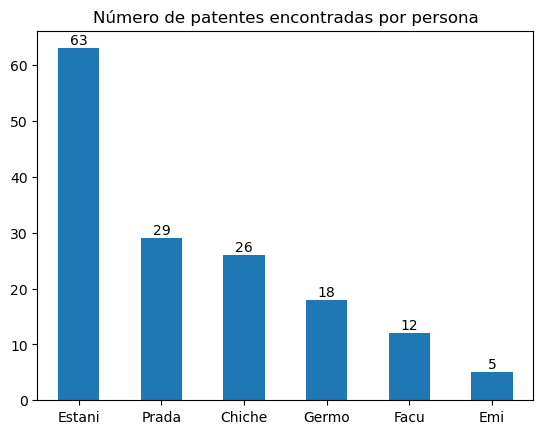

In [67]:
def plot_number_found(df: pd.DataFrame):
    # Plot the number of times each person found a patent ordered by the number of times they found a patent in descending order
    found_by = df.groupby("encontradaPor").size().sort_values(ascending=False)

    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in found_by:
            found_by[participant] = 0

    found_by.plot(kind="bar")

    # Remove the x label
    plt.xlabel("")

    # Rotate the x labels
    plt.xticks(rotation=0)

    # Put the number of times found on top of the bars
    biggest = found_by.max()
    space_between = biggest * 0.01

    for i in range(len(found_by)):
        plt.text(
            i,
            found_by.values[i] + space_between,
            found_by.values[i],
            ha="center",
        )

    plt.title("Número de patentes encontradas por persona")
    plt.show()

plot_number_found(df.copy(deep=True))

### Patentes encontradas a lo largo del tiempo, marcando el mejor día

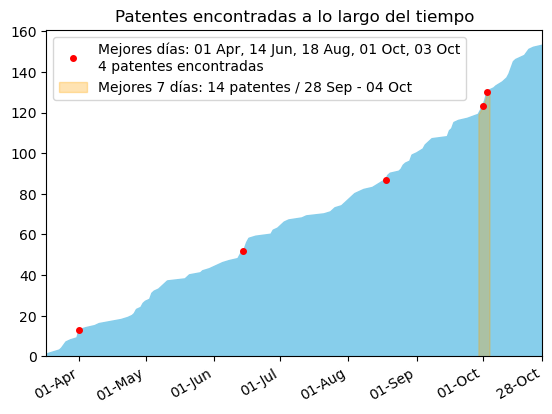

In [68]:
def plot_found_progress(df: pd.DataFrame):
    # Calculate cumulative number of patents found over time
    found_over_time = df.groupby("fecha").size().cumsum()

    # Plot the cumulative number of patents found as an area chart
    found_over_time.plot(kind="area", color="skyblue", zorder=1)

    # Remove the x label and format the x-axis to display day and month
    plt.xlabel("")
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%d-%b"))

    # Generate list of the first day of each month in the data range
    start_date = found_over_time.index.min()
    end_date = found_over_time.index.max()
    first_days_of_month = pd.date_range(start=start_date, end=end_date, freq="MS")  # "MS" is month start

    # Include the last date if it’s more than 7 days from the last tick
    if (end_date - first_days_of_month[-1]).days > 7:
        first_days_of_month = first_days_of_month.append(pd.DatetimeIndex([end_date]))

    # Set x-ticks to the first day of each month and, optionally, the last date
    plt.gca().set_xticks(first_days_of_month)

    # Set the x-axis limits to avoid extending beyond the data range
    plt.xlim(start_date, end_date)

    # Mark the best days in terms of patents found
    daily_counts = df.groupby("fecha").size()
    best_days = daily_counts.nlargest().index
    best_day_formatted = ", ".join(best_days.strftime("%d %b"))
    patents_found = daily_counts.max()
    height_best_day = found_over_time.loc[best_days]
    plt.plot_date(
        best_days,
        height_best_day,
        color="red",
        label=f"Mejores días: {best_day_formatted}\n{patents_found} patentes encontradas",
        zorder=3,
        markersize=4,
    )

    # Create a dataframe with every day even if no patents were found
    all_days = pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max())
    daily_counts = daily_counts.reindex(all_days).fillna(0)

    # Calculate the rolling 7-day sum, centered for accurate window alignment
    rolling_sum_7days = daily_counts.rolling(window=7, min_periods=7).sum()
    best_7_days_start = rolling_sum_7days.idxmax() - pd.Timedelta(days=6)
    best_7_days_end = best_7_days_start + pd.Timedelta(days=6)

    best_7_days_sum = int(rolling_sum_7days.max())

    # Highlight the range of best 7 days to the top of the cumulative curve
    plt.fill_between(
        found_over_time.index,
        found_over_time,
        where=(found_over_time.index >= best_7_days_start) & (found_over_time.index <= best_7_days_end),
        color="orange",
        alpha=0.3,
        label=f"Mejores 7 días: {best_7_days_sum} patentes / {best_7_days_start.strftime('%d %b')} - {best_7_days_end.strftime('%d %b')}",
        zorder=2
    )

    plt.legend(loc="upper left")
    plt.title("Patentes encontradas a lo largo del tiempo")
    plt.show()

plot_found_progress(df.copy(deep=True))

### Distribución de patentes encontradas por momento del día

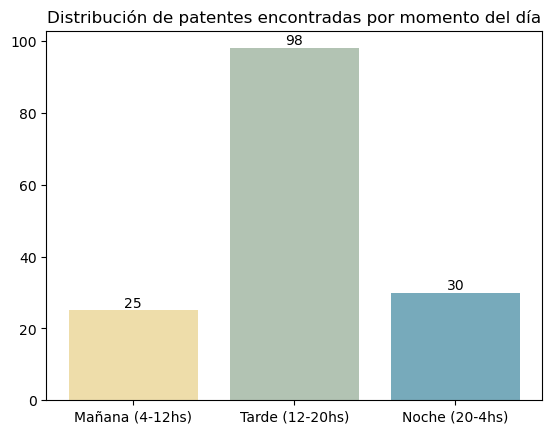

In [69]:
def plot_hour_distribution(df: pd.DataFrame):
    # Plot the distribution of the hour in which the patents were found
    found_at_hour = df.groupby(df["horaDelDia"]).size()

    # Add the missing hours
    for i in range(24):
        if i not in found_at_hour.index:
            found_at_hour[i] = 0

    found_at_hour = found_at_hour.sort_index()

    # Distribute in morning, afternoon and night
    morning = found_at_hour.loc[4:11].sum()
    afternoon = found_at_hour.loc[12:19].sum()
    night = found_at_hour.loc[20:23].sum() + found_at_hour.loc[0:3].sum()

    # Plot the distribution of the parts of the day with gradient colors
    plt.bar(
        ["Mañana (4-12hs)", "Tarde (12-20hs)", "Noche (20-4hs)"],
        [morning, afternoon, night],
        color=sns.color_palette("blend:#EDA,#7AB", 3),
    )

    # Put the number of patents found on top of the bars
    biggest = max(morning, afternoon, night)
    space_between = biggest * 0.01

    for i in range(3):
        plt.text(
            i,
            [morning, afternoon, night][i] + space_between,
            [morning, afternoon, night][i],
            ha="center",
        )

    plt.title("Distribución de patentes encontradas por momento del día")
    plt.show()


plot_hour_distribution(df.copy(deep=True))

### Distribuición de patentes encontradas por día de la semana

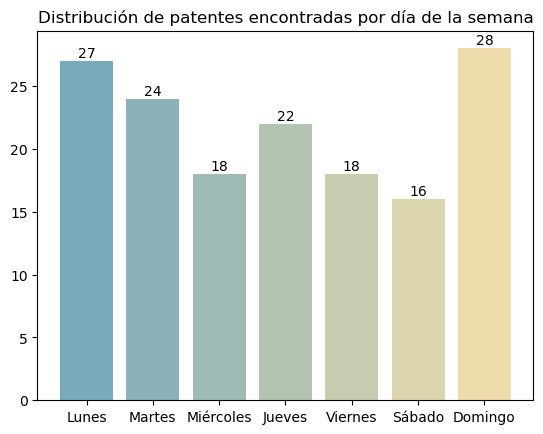

In [70]:
def plot_day_distribution(df: pd.DataFrame):
    # Plot the distribution of the day of the week in which the patents were found
    found_on_day = df.groupby(df["fecha"].dt.day_name()).size()

    day_order = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]

    # Sort the days of the week
    found_on_day = found_on_day.reindex(day_order)

    # Add the missing days
    for day in day_order:
        if day not in found_on_day.index:
            found_on_day[day] = 0

    # Transform the index to spanish
    found_on_day.index = [
        "Lunes",
        "Martes",
        "Miércoles",
        "Jueves",
        "Viernes",
        "Sábado",
        "Domingo",
    ]

    # Plot the distribution of the days of the week with gradient colors
    plt.bar(
        found_on_day.index,
        found_on_day,
        color=sns.color_palette("blend:#7AB,#EDA", 7),
    )

    # Put the number of patents found on top of the bars
    biggest = found_on_day.max()
    space_between = biggest * 0.01 # 1% of the biggest number

    for i in range(7):
        plt.text(
            i,
            found_on_day.values[i] + space_between,
            found_on_day.values[i],
            ha="center",
        )

    plt.title("Distribución de patentes encontradas por día de la semana")
    plt.show()

plot_day_distribution(df.copy(deep=True))

### Distribución de marcas de autos encontradas

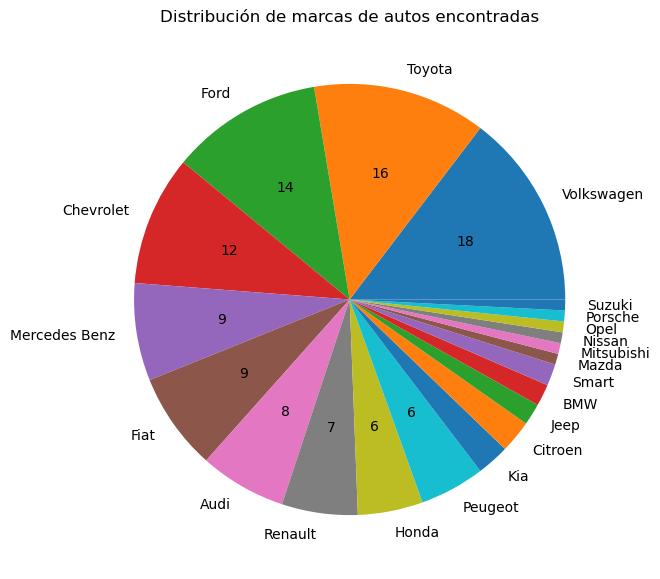

In [71]:
def car_brand_distribution(df: pd.DataFrame):
    # Plot the distribution of the car brands of the patents found
    car_brands = df.groupby("marca").size().sort_values(ascending=False)

    # Calculate the total number of items to use in the autopct function
    total = car_brands.sum()

    # Function to conditionally display the number
    def autopct(pct):
        absolute = round(pct / 100.0 * total)
        return str(absolute) if pct > 3 else ""

    # Plot the distribution of the car brands with gradient colors
    plt.figure(figsize=(7, 7))
    plt.pie(
        car_brands,
        labels=car_brands.index,
        autopct=autopct
    )

    plt.title("Distribución de marcas de autos encontradas")
    plt.show()


car_brand_distribution(df.copy(deep=True))

### Distribución de tipos de vehículos encontrados

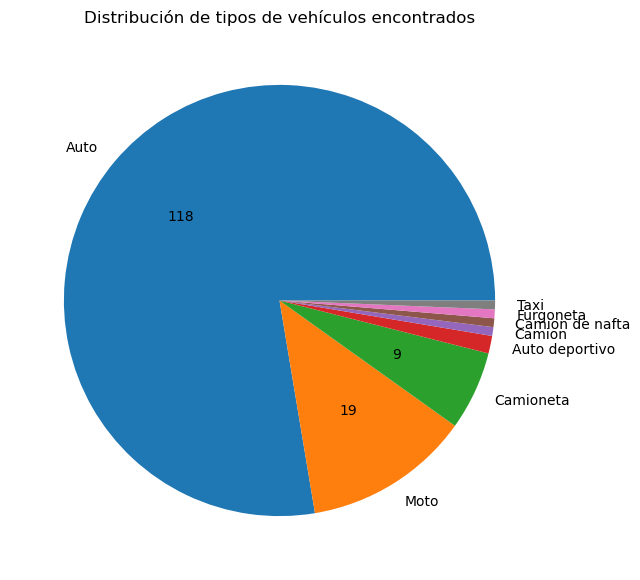

In [72]:
def car_type_distribution(df: pd.DataFrame):
    # Plot the distribution of the car types of the patents found
    car_types = df.groupby("vehiculo").size().sort_values(ascending=False)

    # Calculate the total number of items to use in the autopct function
    total = car_types.sum()

    # Function to conditionally display the number
    def autopct(pct):
        absolute = round(pct / 100.0 * total)
        return str(absolute) if pct > 3 else ""

    # Plot the distribution of the car types with gradient colors
    plt.figure(figsize=(7, 7))
    plt.pie(
        car_types,
        labels=car_types.index,
        autopct=autopct
    )

    plt.title("Distribución de tipos de vehículos encontrados")
    plt.show()

car_type_distribution(df.copy(deep=True))

## Estadisticas Copadas

### Mejor racha de patentes encontradas seguidas

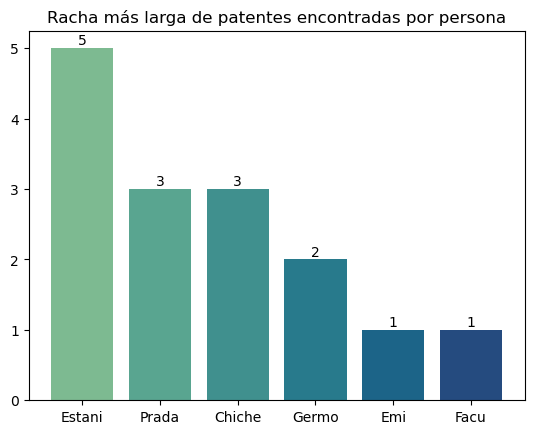

In [73]:
def find_longest_streak_for_each_participant(df: pd.DataFrame):
    all_participants = df["encontradaPor"].unique()

    longest_streak_by_participant = dict()

    for participant in all_participants:
        longest_streak = 0
        current_streak = 0
        for i in range(len(df)):
            if df["encontradaPor"].iloc[i] == participant:
                current_streak += 1
                if current_streak >= longest_streak:
                    longest_streak = current_streak
            else:
                current_streak = 0
        longest_streak_by_participant[participant] = longest_streak

    return longest_streak_by_participant

def plot_longest_streak():
    longest_streak_by_participant = find_longest_streak_for_each_participant(df)

    # Sort the participants by the length of their longest streak
    sorted_participants = sorted(
        longest_streak_by_participant.items(), key=lambda x: x[1], reverse=True
    )

    # Plot the longest streak of each participant
    plt.bar(
        [participant[0] for participant in sorted_participants],
        [participant[1] for participant in sorted_participants],
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the number of patents found on top of the bars
    biggest = sorted_participants[0][1]
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants[i][1] + space_between,
            sorted_participants[i][1],
            ha="center",
        )

    plt.title("Racha más larga de patentes encontradas por persona")
    plt.show()


plot_longest_streak()

### Patentes totales vistas por probabilidad

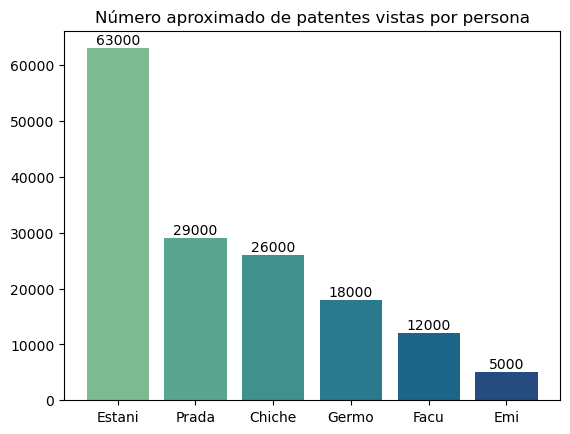

In [74]:
def plot_expected_total_patentes_seen_for_each_participant(df: pd.DataFrame):
    patentes_found_by_participant = df.groupby("encontradaPor").size()

    # If we asume that all patentes are equally likely to be found,
    # the probability of finding a patente is 1/1000
    probability = 1 / 1000

    # Calculate the expected number of patents found by each participant
    expected_patentes_found = patentes_found_by_participant * (1 / probability)

    # Convert the expected number of patents found to integers
    expected_patentes_found = expected_patentes_found.astype(int)

    # Sort the participants by the expected number of patents found
    sorted_participants = expected_patentes_found.sort_values(ascending=False)

    # Plot the expected number of patents found by each participant
    plt.bar(
        sorted_participants.index,
        sorted_participants,
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the number of patents found on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants.values[i] + space_between,
            round(sorted_participants.values[i], 2),
            ha="center",
        )

    plt.title("Número aproximado de patentes vistas por persona")
    plt.show()


plot_expected_total_patentes_seen_for_each_participant(df.copy(deep=True))

### Proyección de cuando vamos a terminar de encontrar todas las patentes

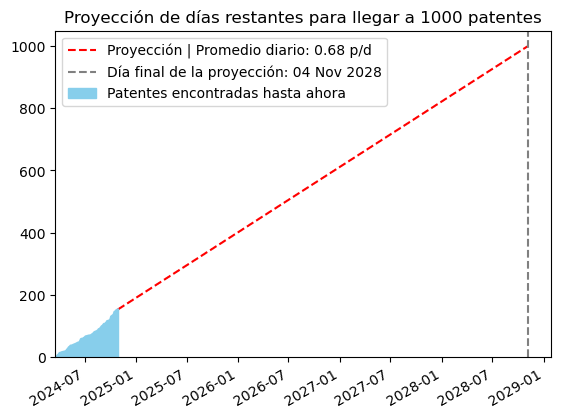

In [75]:
def plot_end_day_proyection(df: pd.DataFrame):
    # Number of days since the first patent was found to the last day of the dataset
    days_since_start = (df["fecha"].max() - df["fecha"].min()).days

    # Number of days to reach 1000 patents
    days_to_1000 = 1000 * days_since_start / len(df)

    # Average number of patents found per day
    patentes_average = len(df) / days_since_start

    # Patentes to reach 1000
    patentes_to_1000 = 1000 - len(df)

    # Create a list with the predicted dates
    days_proyection = []
    day_frequency = days_to_1000 / patentes_to_1000
    for i in range(patentes_to_1000):
        days_proyection.append(
            df["fecha"].max() + pd.DateOffset(days=day_frequency * i)
        )

    patentes_proyection = np.arange(patentes_to_1000) + len(df)

    # Plot the proyection
    plt.plot(
        days_proyection,
        patentes_proyection,
        color="red",
        label="Proyección | Promedio diario: {:.2f} p/d".format(patentes_average),
        linestyle="--",
    )

    # Plot line indicating the final date
    plt.axvline(
        days_proyection[-1],
        color="gray",
        linestyle="--",
        label=f"Día final de la proyección: {days_proyection[-1].strftime('%d %b %Y')}",
    )

    # Plot area chart with the number of patents found over time
    found_over_time = df.groupby("fecha").size().cumsum()
    found_over_time.plot(kind="area", color="skyblue", label="Patentes encontradas hasta ahora")

    # x-axis limit to start from the first date
    plt.xlim(df["fecha"].min())

    # Remove the x label
    plt.xlabel("")

    plt.title("Proyección de días restantes para llegar a 1000 patentes")

    plt.legend(
        loc="upper left"
    )

    plt.show()


plot_end_day_proyection(df.copy(deep=True))

### Cuanto pagaría una apuesta de quien encuentra la próxima patente

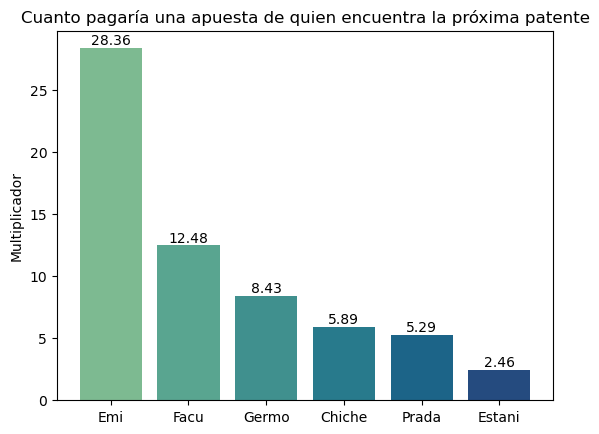

In [76]:
def calculate_odds_of_finding_the_next_patente_for_each_participant(df: pd.DataFrame):
    patentes_found_by_participant = df.groupby("encontradaPor").size()
    
    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in patentes_found_by_participant:
            patentes_found_by_participant[participant] = 0

    # We also need to add an Epsilon to avoid having a probability of 0
    epsilon = 0.5

    # Add epsilon to the number of patentes found by each participant
    patentes_found_by_participant += epsilon

    # Calculate the new total of adjusted patentes found
    total_patentes_found = patentes_found_by_participant.sum()

    # Calculate the odds of finding the next patente for each participant
    odds_of_finding_next_patente = patentes_found_by_participant / total_patentes_found

    return odds_of_finding_next_patente

def plot_betting_odds_of_finding_the_next_patente(df: pd.DataFrame):
    odds_of_finding_next_patente = calculate_odds_of_finding_the_next_patente_for_each_participant(df)

    # Calculate the betting odds for each participant
    betting_odds_for_each_participant = 1 / odds_of_finding_next_patente

    # Sort the participants by the odds of finding the next patente
    sorted_participants = betting_odds_for_each_participant.sort_values(ascending=False)

    # Plot the odds of finding the next patente for each participant
    plt.bar(
        sorted_participants.index,
        sorted_participants,
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the odds of finding the next patente on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants.values[i] + space_between,
            round(sorted_participants.values[i], 2),
            ha="center",
        )

    plt.ylabel("Multiplicador")

    plt.title("Cuanto pagaría una apuesta de quien encuentra la próxima patente")
    plt.show()

plot_betting_odds_of_finding_the_next_patente(df.copy(deep=True))

### Predicción de distribución para el próximo centésimo

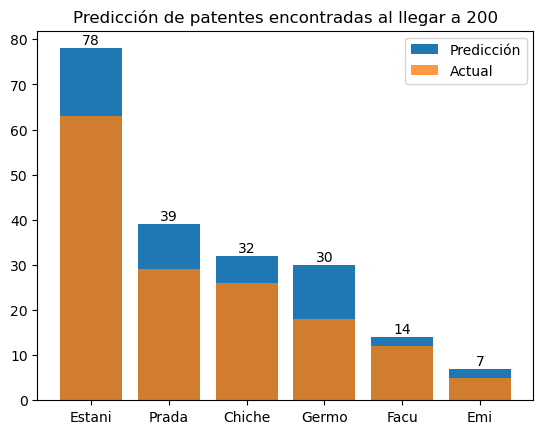

In [77]:
import random

def calculate_odds_of_finding_the_next_patente_for_each_participant(df: pd.DataFrame):
    patentes_found_by_participant = df.groupby("encontradaPor").size()

    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in patentes_found_by_participant:
            patentes_found_by_participant[participant] = 0

    # We also need to add an Epsilon to avoid having a probability of 0
    epsilon = 0.5

    # Add epsilon to the number of patentes found by each participant
    patentes_found_by_participant += epsilon

    # Calculate the new total of adjusted patentes found
    total_patentes_found = patentes_found_by_participant.sum()

    # Calculate the odds of finding the next patente for each participant
    odds_of_finding_next_patente = (
        patentes_found_by_participant / total_patentes_found
    )

    return odds_of_finding_next_patente


def plot_prediction_distribution_for_next_hundredth(df: pd.DataFrame):
    found_by_participant = df.groupby("encontradaPor").size()

    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in found_by_participant:
            found_by_participant[participant] = 0

    left_until_next_hundredth = 100 - (len(df) % 100)

    # Calculate the odds of finding the next patente for each participant
    odds_of_finding_next_patente = calculate_odds_of_finding_the_next_patente_for_each_participant(df)

    # Complete the patentes found by each participant to the next hundredth
    found_by_participant_prediction = found_by_participant.copy()
    for _ in range(left_until_next_hundredth):
        participant = random.choices(odds_of_finding_next_patente.index, odds_of_finding_next_patente)[0]
        found_by_participant_prediction[participant] += 1

    # Sort the participants by the number of patentes found
    found_by_participant_prediction = found_by_participant_prediction.sort_values(ascending=False)

    # Plot the distribution of the patentes found by each participant
    plt.bar(
        found_by_participant_prediction.index,
        found_by_participant_prediction
    )

    # Plot the previous number of patentes found by each participant
    plt.bar(
        found_by_participant.index,
        found_by_participant,
        alpha=0.8,
    )

    # Put the number of patents found on top of the bars
    biggest = found_by_participant_prediction.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(found_by_participant_prediction)):
        plt.text(
            i,
            found_by_participant_prediction.values[i] + space_between,
            found_by_participant_prediction.values[i],
            ha="center",
        )

    plt.legend(["Predicción", "Actual"])

    plt.title(f"Predicción de patentes encontradas al llegar a {len(df) + left_until_next_hundredth}")
    plt.show()

plot_prediction_distribution_for_next_hundredth(df.copy(deep=True))

### Racha más larga de patentes no encontradas

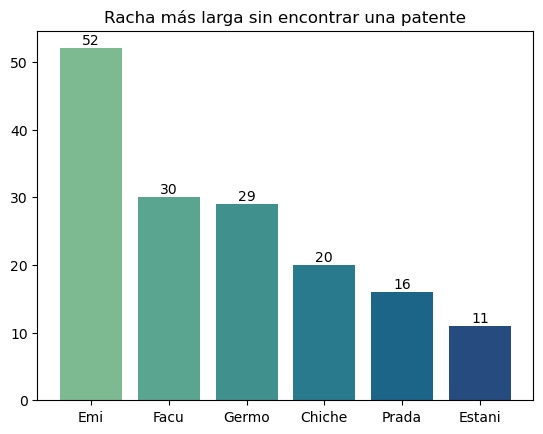

In [78]:
def plot_longest_dry_streak(df: pd.DataFrame):
    # Calculate the max number of days without finding a patent for each participant
    longest_dry_streak_by_participant = dict()

    # Start counting from the first patent found of each participant
    for participant in participants:
        started_playing = False
        longest_dry_streak = 0
        current_dry_streak = 0
        for i in range(len(df)):
            if df["encontradaPor"].iloc[i] != participant:
                if not started_playing:
                    continue
                current_dry_streak += 1
                if current_dry_streak >= longest_dry_streak:
                    longest_dry_streak = current_dry_streak
            else:
                started_playing = True
                current_dry_streak = 0
        longest_dry_streak_by_participant[participant] = longest_dry_streak

    # Sort the participants by the length of their longest dry streak
    sorted_participants = sorted(
        longest_dry_streak_by_participant.items(), key=lambda x: x[1], reverse=True
    )

    # Plot the longest dry streak of each participant
    plt.bar(
        [participant[0] for participant in sorted_participants],
        [participant[1] for participant in sorted_participants],
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the number of days without finding a patent on top of the bars
    biggest = sorted_participants[0][1]
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants[i][1] + space_between,
            sorted_participants[i][1],
            ha="center",
        )

    plt.title("Racha más larga sin encontrar una patente")
    plt.show()

plot_longest_dry_streak(df.copy(deep=True))

### Proporción de patentes encontradas que no eran de autos

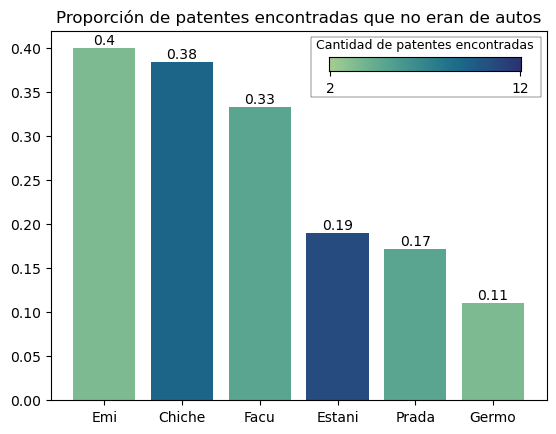

In [79]:
from matplotlib.patches import Rectangle

def plot_non_car_vehicule_found_proportion(df: pd.DataFrame):
    # Plot the proportion of times each participant found a non-car patent

    non_car_found_by = df[df["vehiculo"] != "Auto"].groupby("encontradaPor").size()
    patentes_found_by_participant = df.groupby("encontradaPor").size()

    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in patentes_found_by_participant:
            patentes_found_by_participant[participant] = 0
        if participant not in non_car_found_by:
            non_car_found_by[participant] = 0

    # Calculate the proportion of non-car patents found by each participant
    proportion_non_car_found = non_car_found_by / patentes_found_by_participant

    # Sort the participants by the proportion of non-car patents found
    sorted_participants = proportion_non_car_found.sort_values(ascending=False)

    # Get the number of non-car patents found for coloring the bars
    patent_counts = non_car_found_by[sorted_participants.index]

    # Create a gradient color based on the number of non-car patents found
    norm = plt.Normalize(patent_counts.min(), patent_counts.max())
    colors = sns.color_palette("crest", len(sorted_participants))
    bar_colors = [
        colors[int(norm(count) * (len(colors) - 1))] for count in patent_counts
    ]

    # Create the bar plot
    fig, ax = plt.subplots()  # Adjust the figure size as needed
    bars = ax.bar(
        sorted_participants.index,
        sorted_participants,
        color=bar_colors,
    )

    # Put the proportion of non-car patents found on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        ax.text(
            i,
            sorted_participants.values[i] + space_between,
            round(sorted_participants.values[i], 2),
            ha="center",
        )

    # Create a gradient legend inside the plot
    gradient = np.linspace(patent_counts.min(), patent_counts.max(), 100)
    gradient_colors = sns.color_palette("crest", 100)

    # Create a new axis for the gradient legend
    cbar_ax = fig.add_axes([0.56, 0.795, 0.3, 0.03])  # [left, bottom, width, height]
    cbar_ax.imshow([gradient], aspect="auto", cmap="crest", norm=norm)
    cbar_ax.set_xticks([0, 99])
    cbar_ax.set_xticklabels([str(patent_counts.min()), str(patent_counts.max())])
    cbar_ax.set_yticks([])
    cbar_ax.set_title("Cantidad de patentes encontradas", fontsize=9)

    # Draw a rectangle around the gradient legend
    cbar_ax.add_patch(
        Rectangle(
            (-10, -1.9),
            120,
            4.2,
            edgecolor="black",
            facecolor="none",
            lw=0.3,
            clip_on=False,
        )
    )

    ax.set_title("Proporción de patentes encontradas que no eran de autos")
    plt.show()


plot_non_car_vehicule_found_proportion(df.copy(deep=True))

### El que más patentes encontró en la noche

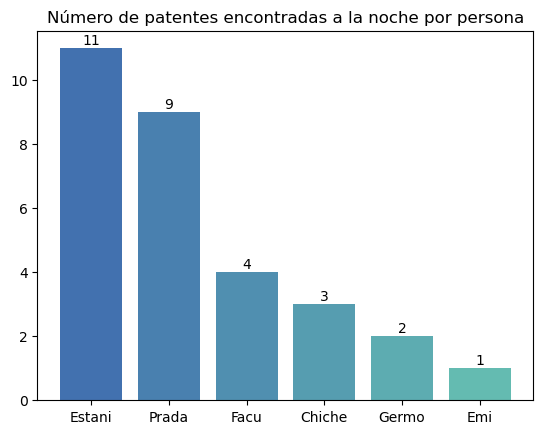

In [80]:
def plot_found_at_night_distribution(df: pd.DataFrame):
    # Plot the distribution of the number of patents found at night by each participant
    found_at_hour = df.groupby(df["horaDelDia"]).size()

    # Night is considered from 20hs to 4hs

    found_at_hour = found_at_hour.reindex(range(24), fill_value=0)

    # Calculate the number of patents found at night by each participant
    found_at_night_by_participant = df[df["horaDelDia"].isin(range(20, 24)) | df["horaDelDia"].isin(range(4))].groupby("encontradaPor").size()

    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in found_at_night_by_participant:
            found_at_night_by_participant[participant] = 0

    # Sort the participants by the number of patents found at night
    sorted_participants = found_at_night_by_participant.sort_values(ascending=False)

    # Plot the number of patents found at night by each participant
    plt.bar(
        sorted_participants.index,
        sorted_participants,
        color=sns.color_palette("blend:#4271af,#64bbb1", len(sorted_participants)),
    )

    # Put the number of patents found at night on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants.values[i] + space_between,
            sorted_participants.values[i],
            ha="center",
        )

    plt.title("Número de patentes encontradas a la noche por persona")
    plt.show()


plot_found_at_night_distribution(df.copy(deep=True))

### El que más patentes encontró en la mañana

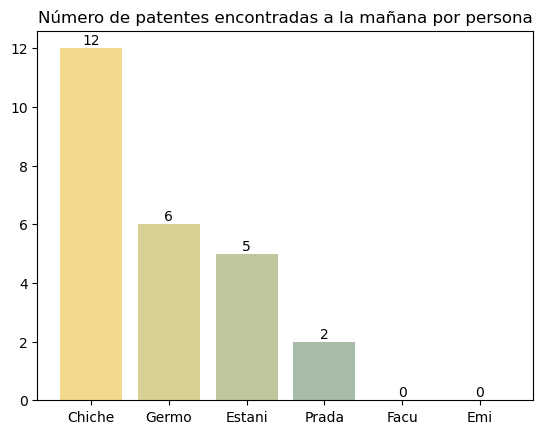

In [81]:
def plot_found_at_morning_distribution(df: pd.DataFrame):
    # Plot the distribution of the number of patents found in the morning by each participant
    found_at_hour = df.groupby(df["horaDelDia"]).size()

    # Morning is considered from 4hs to 12hs
    found_at_hour = found_at_hour.reindex(range(24), fill_value=0)

    # Calculate the number of patents found in the morning by each participant
    found_at_morning_by_participant = df[df["horaDelDia"].isin(range(4, 12))].groupby("encontradaPor").size()

    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in found_at_morning_by_participant:
            found_at_morning_by_participant[participant] = 0

    # Sort the participants by the number of patents found in the morning
    sorted_participants = found_at_morning_by_participant.sort_values(ascending=False)

    # Plot the number of patents found in the morning by each participant
    plt.bar(
        sorted_participants.index,
        sorted_participants,
        color=sns.color_palette("blend:#f2d98c,#7AB", len(sorted_participants)),
    )

    # Put the number of patents found in the morning on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants.values[i] + space_between,
            sorted_participants.values[i],
            ha="center",
        )

    plt.title("Número de patentes encontradas a la mañana por persona")
    plt.show()

plot_found_at_morning_distribution(df.copy(deep=True))

### El que más números primos encontró

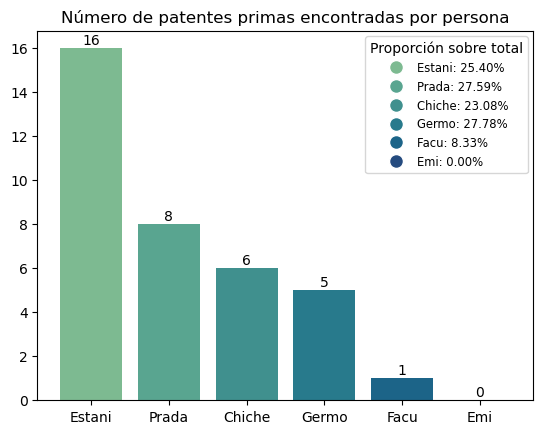

In [82]:
from sympy import sieve

def plot_most_prime_patentes_found(df: pd.DataFrame):
    # Plot the number of prime patents found by each participant

    # Generate all the prime numbers up to 1000
    prime_numbers = list(sieve.primerange(0, 1000))

    # Calculate the number of prime patents found by each participant
    prime_patentes_found_by_participant = df["patente"].isin(prime_numbers).groupby(df["encontradaPor"]).sum()

    # Add the people that didn't find any patent
    for participant in participants:
        if participant not in prime_patentes_found_by_participant:
            prime_patentes_found_by_participant[participant] = 0

    # Sort the participants by the number of prime patents found
    sorted_participants = prime_patentes_found_by_participant.sort_values(ascending=False)

    # Plot the number of prime patents found by each participant
    plt.bar(
        sorted_participants.index,
        sorted_participants,
        color=sns.color_palette("crest", len(sorted_participants)),
    )

    # Put the number of prime patents found on top of the bars
    biggest = sorted_participants.max()
    space_between = biggest * 0.01  # 1% on top

    for i in range(len(sorted_participants)):
        plt.text(
            i,
            sorted_participants.values[i] + space_between,
            sorted_participants.values[i],
            ha="center",
        )

    proporcion = prime_patentes_found_by_participant / df.groupby("encontradaPor").size()

    # Create a legend with the number of non-car patents found for each participant to 2 decimal places
    labels = [
        f"{participant}: {proporcion[participant]:.2%}"
        for participant in sorted_participants.index
    ]

    # Create a handle for each bar to use in the legend
    legend_handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=sns.color_palette("crest", len(sorted_participants))[i],
            markersize=10,
        )
        for i in range(len(sorted_participants))
    ]

    # Place the legend inside the plot
    plt.legend(
        legend_handles,
        labels,
        title="Proporción sobre total",
        fontsize="small",
        frameon=True,
        loc="upper right",
    )

    plt.title("Número de patentes primas encontradas por persona")
    plt.show()

plot_most_prime_patentes_found(df.copy(deep=True))

## Correlaciones

Aún sin completar

## Extras

### Cantidad de patentes capicúas encontradas por persona

### Proporción de patentes pares e impares por persona